In [54]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import glob
import matplotlib.pyplot as plt
import math
import numpy as np
print(np.__version__)
import pandas as pd
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay, PredictionErrorDisplay
from tensorflow.keras.datasets import mnist

import autokeras as ak
pd.set_option('display.max_columns', None)

from IPython.display import SVG, display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.26.2


## Get the hang of the workflow using the mnist data

In [35]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)  # (60000, 28, 28)
print(y_train.shape)  # (60000,)
print(y_train[:3])  # array([7, 2, 1], dtype=uint8)

(60000, 28, 28)
(60000,)
[5 0 4]


In [36]:
# Initialize the image classifier.
clf = ak.ImageClassifier(overwrite=True, max_trials=1)
# Feed the image classifier with training data.
clf.fit(x_train, y_train, epochs=10)

# Predict with the best model.
predicted_y = clf.predict(x_test)
print(predicted_y)

# Evaluate the best model with testing data.
print(clf.evaluate(x_test, y_test))

Trial 1 Complete [00h 03m 52s]
val_loss: 0.04004310816526413

Best val_loss So Far: 0.04004310816526413
Total elapsed time: 00h 03m 52s
Epoch 1/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.1619 - accuracy: 0.9504
Epoch 2/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0749 - accuracy: 0.9764
Epoch 3/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0622 - accuracy: 0.9810
Epoch 4/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0508 - accuracy: 0.9845
Epoch 5/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0478 - accuracy: 0.9843
Epoch 6/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0420 - accuracy: 0.9869
Epoch 7/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0377 - accuracy: 0.9876
Epoch 8/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0343 - accuracy: 0.9892
Epoch 9/10
1875/1875 [==========

INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


313/313 [==============================] - 1s 4ms/step
[['7']
 ['2']
 ['1']
 ...
 ['4']
 ['5']
 ['6']]
313/313 [==============================] - 1s 4ms/step - loss: 0.0340 - accuracy: 0.9898
[0.03401508182287216, 0.989799976348877]


# Now work with PTA jMSFS. Here is a function to load the simulations and reshape the jmsfs to what tf expects

In [55]:
def load_simulations(simfile, nrows=None, npops=4, nsamps=(3,2)):
    """
    Load in the simulation data, if it exists.
    """
    dat = pd.read_csv(simfile, sep=" ")

    if nrows == None:
        nrows = len(dat)

    # Split the params and jsfs data
    # The dataframe is formated so that the first bin of the jMSFS is 0
    idx = dat.columns.get_loc('0')
    params = dat.iloc[:nrows, :idx]
    jmsfs = dat.iloc[:nrows, idx:]
    nrows = min(len(jmsfs), nrows)
    jmsfs = jmsfs.values.reshape(nrows,
                        npops,
                        nsamps[0]*2+1,
                        nsamps[1]*2+1)
    # Note: Autokeras expects the structure of the data to be slightly different so we have to shift around the axes
    jmsfs = np.swapaxes(jmsfs, 1, 3)
    jmsvs = np.swapaxes(jmsfs, 1, 2)

    return params, jmsfs
params, jmsfs = load_simulations("./default_PTA/2D-test-SIMOUT.csv", npops=5, nsamps=(10,10))
print(len(params), jmsfs.shape)
params

4400 (4400, 21, 21, 5)


,zeta,zeta_e,r_moderns_mean,r_moderns_std,r_moderns_skewness,r_moderns_kurtosis,r_moderns_median,r_moderns_iqr,Ne_s_mean,Ne_s_std,Ne_s_skewness,Ne_s_kurtosis,Ne_s_median,Ne_s_iqr
0,0.904,5,-0.10,0.0,0.0,-3.0,-0.10,0.0,10000.0,0.0,0.0,-3.0,10000.0,0.0
1,0.499,3,-0.10,0.0,0.0,-3.0,-0.10,0.0,10000.0,0.0,0.0,-3.0,10000.0,0.0
2,0.740,4,-0.10,0.0,0.0,-3.0,-0.10,0.0,10000.0,0.0,0.0,-3.0,10000.0,0.0
3,0.599,3,-0.10,0.0,0.0,-3.0,-0.10,0.0,10000.0,0.0,0.0,-3.0,10000.0,0.0
4,0.941,5,-0.10,0.0,0.0,-3.0,-0.10,0.0,10000.0,0.0,0.0,-3.0,10000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4395,0.978,5,-0.01,0.0,0.0,-3.0,-0.01,0.0,100000.0,0.0,0.0,-3.0,100000.0,0.0
4396,0.595,3,-0.01,0.0,0.0,-3.0,-0.01,0.0,100000.0,0.0,0.0,-3.0,100000.0,0.0
4397,0.897,5,-0.01,0.0,0.0,-3.0,-0.01,0.0,100000.0,0.0,0.0,-3.0,100000.0,0.0
4398,0.072,1,-0.01,0.0,0.0,-3.0,-0.01,0.0,100000.0,0.0,0.0,-3.0,100000.0,0.0


# A very hackish and "by-hand" test/train split routine

In [46]:
# Set the name of the target parameter here if you want to change it
z = params["Ne_s_mean"].astype(str)

idxs = np.random.choice(len(z), int(len(z)*0.75), replace=False)
mask = np.zeros(len(z), dtype=bool)
mask[idxs] = True
print(np.sum(mask))

x_train = jmsfs[mask]
x_test = jmsfs[~mask]
y_train = z[mask]
y_test = z[~mask]

#idx = 750
#x_train = jmsfs[:idx]
#y_train = z[:idx]
#x_test = jmsfs[idx:]
#y_test = z[idx:]
print(np.shape(x_train), np.shape(x_test))
x_train[0]


16500
(16500, 41, 41, 10) (5500, 41, 41, 10)


array([[[  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [245.5, 241.5, 221. , ..., 209.5, 205. , 203.5],
        [ 67.5,  65.5,  61.5, ...,  51.5,  51.5,  45. ],
        ...,
        [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ]],

       [[218.5, 212. , 197. , ..., 166.5, 161.5, 157. ],
        [101. ,  98.5,  96.5, ...,  84. ,  77.5,  75. ],
        [ 69. ,  58. ,  54. , ...,  39. ,  34. ,  34. ],
        ...,
        [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ]],

       [[ 67. ,  59.5,  57. , ...,  52. ,  47. ,  35.5],
        [ 55.5,  53.5,  51. , ...,  38. ,  35. ,  33. ],
        [ 62. ,  55.5,  46.5, ...,  31.5,  30.5,  26. ],
        ...,
        [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. , ...,   0. ,   0

# Run a classifier (works for zeta_e becuase its int values are converted to categorical)

In [49]:
# Initialize the image classifier.
clf = ak.ImageClassifier(overwrite=True, max_trials=1)
# Feed the image classifier with training data.
clf.fit(x_train, y_train, epochs=5)

# Predict with the best model.
predicted_y = clf.predict(x_test)

# Evaluate the best model with testing data.
print(clf.evaluate(x_test, y_test))

Trial 1 Complete [00h 01m 15s]
val_loss: 0.0

Best val_loss So Far: 0.0
Total elapsed time: 00h 01m 15s
Epoch 1/5
516/516 [==============================] - 15s 27ms/step - loss: 0.5863 - accuracy: 0.9445
Epoch 2/5
516/516 [==============================] - 14s 27ms/step - loss: 0.2059 - accuracy: 0.9770
Epoch 3/5
516/516 [==============================] - 14s 27ms/step - loss: 0.2040 - accuracy: 0.9950
Epoch 4/5
516/516 [==============================] - 14s 27ms/step - loss: 1.0284e-10 - accuracy: 1.0000
Epoch 5/5
516/516 [==============================] - 14s 27ms/step - loss: 1.6910e-10 - accuracy: 1.0000
INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


172/172 [==============================] - 2s 7ms/step - loss: 1.1425e-13 - accuracy: 1.0000
[1.142478445832415e-13, 1.0]


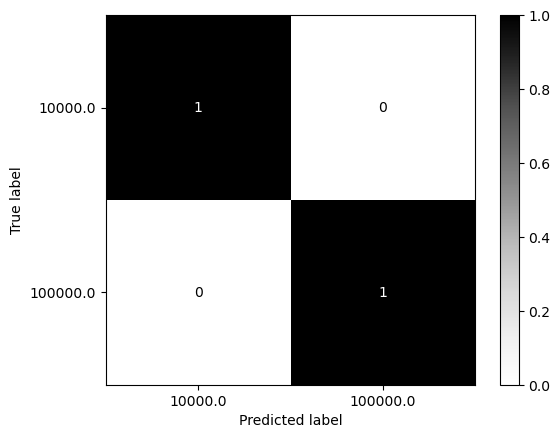

In [53]:
ConfusionMatrixDisplay.from_predictions(y_test, [x[0] for x in predicted_y], cmap="Greys", normalize="true")

0        10000.0
2        10000.0
3        10000.0
4        10000.0
5        10000.0
          ...   
1959    100000.0
1986    100000.0
1990    100000.0
1998    100000.0
1999    100000.0
Name: Ne_s_mean, Length: 500, dtype: float64

# Regression
Here we can set the target to average Ne across all species, which is continuous valued so you can do regression on it

In [41]:
z = params["Ne_s_mean"]

idxs = np.random.choice(len(z), int(len(z)*0.75), replace=False)
mask = np.zeros(len(z), dtype=bool)
mask[idxs] = True

x_train = jmsfs[mask]
x_test = jmsfs[~mask]
y_train = z[mask]
y_test = z[~mask]

#idx = 750
#x_train = jmsfs[:idx]
#y_train = np.log(z[:idx])
#x_test = jmsfs[idx:]
#y_test = np.log(z[idx:])
#print(np.shape(x_train))
#x_train[0]

# Initialize the image regressor.
reg = ak.ImageRegressor(overwrite=True, max_trials=2)
# Feed the image regressor with training data.
reg.fit(x_train, y_train, epochs=1)

# Predict with the best model.
predicted_y = reg.predict(x_test)

# Evaluate the best model with testing data.
print(reg.evaluate(x_test, y_test))

Trial 2 Complete [00h 00m 35s]
val_loss: 9810452480.0

Best val_loss So Far: 9810452480.0
Total elapsed time: 00h 01m 10s
47/47 [==============================] - 31s 387ms/step - loss: 5121729024.0000 - mean_squared_error: 5121729024.0000
INFO:tensorflow:Assets written to: ./image_regressor/best_model/assets


INFO:tensorflow:Assets written to: ./image_regressor/best_model/assets


16/16 [==============================] - 2s 73ms/step - loss: 4507072512.0000 - mean_squared_error: 4507072512.0000
[4507072512.0, 4507072512.0]


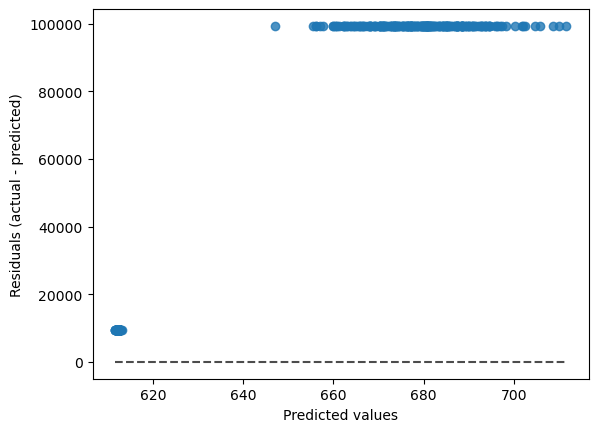

In [42]:
#tmp_ytest = y_test.ravel()
#np.random.shuffle(tmp_ytest)
PredictionErrorDisplay.from_predictions(y_test, predicted_y.ravel(), kind="residual_vs_predicted")

In [52]:
predicted_y

array([['10000.0'],
       ['10000.0'],
       ['10000.0'],
       ...,
       ['100000.0'],
       ['100000.0'],
       ['100000.0']], dtype='<U8')